In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import pickle

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
from sklearn import cluster, metrics, model_selection
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from scipy.special import rel_entr
from scipy.spatial import distance_matrix
from plotly.subplots import make_subplots

plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

# Probabilistic PCA from a GitHub fork (Ludvig Hult) 
# ! pip install git+https://github.com/el-hult/pyppca
from pyppca import ppca

In [2]:
bzcat = pd.read_csv('data/BZCAT_all_features.csv')  # Catalog, all features 
model_df = bzcat.copy()  # model dataframe
model_df.head(3)

,BZCAT5 Source name,RA (J2000.0),Dec (J2000.0),Redshift,Class,Rad_opt_sp_index,alpha_1.1-2.3,alpha_2.3-4.8,alpha_4.8-7.7,alpha_4.8-11.2,...,K-w1,g_var,r_var,i_var,z_var,y_var,Radio_radio_hard,IR_opt_hard,IR_UV_hard,IR_X_hard
0,5BZQJ0000-3221,00 00 20.39,-32 21 01.0,1.275,BZQ,0.707,NaN,0.056,-0.763,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.477429,NaN,-0.434905,0.966619
1,5BZQJ0001-1551,00 01 05.29,-15 51 06.98,2.044,BZQ,0.661,NaN,-0.281,-0.599,-0.788,...,NaN,0.5289,0.144299,0.0861,0.185701,0.341099,-0.473286,-0.40052,-0.189982,NaN
2,5BZQJ0001+1914,00 01 08.62,+19 14 34.18,3.100,BZQ,0.917,-0.117,0.029,0.276,-0.427,...,NaN,0.4077,0.879499,0.8995,0.575199,NaN,-0.335206,0.18340,NaN,NaN


## 1. Cleansing

Missing values heatmap

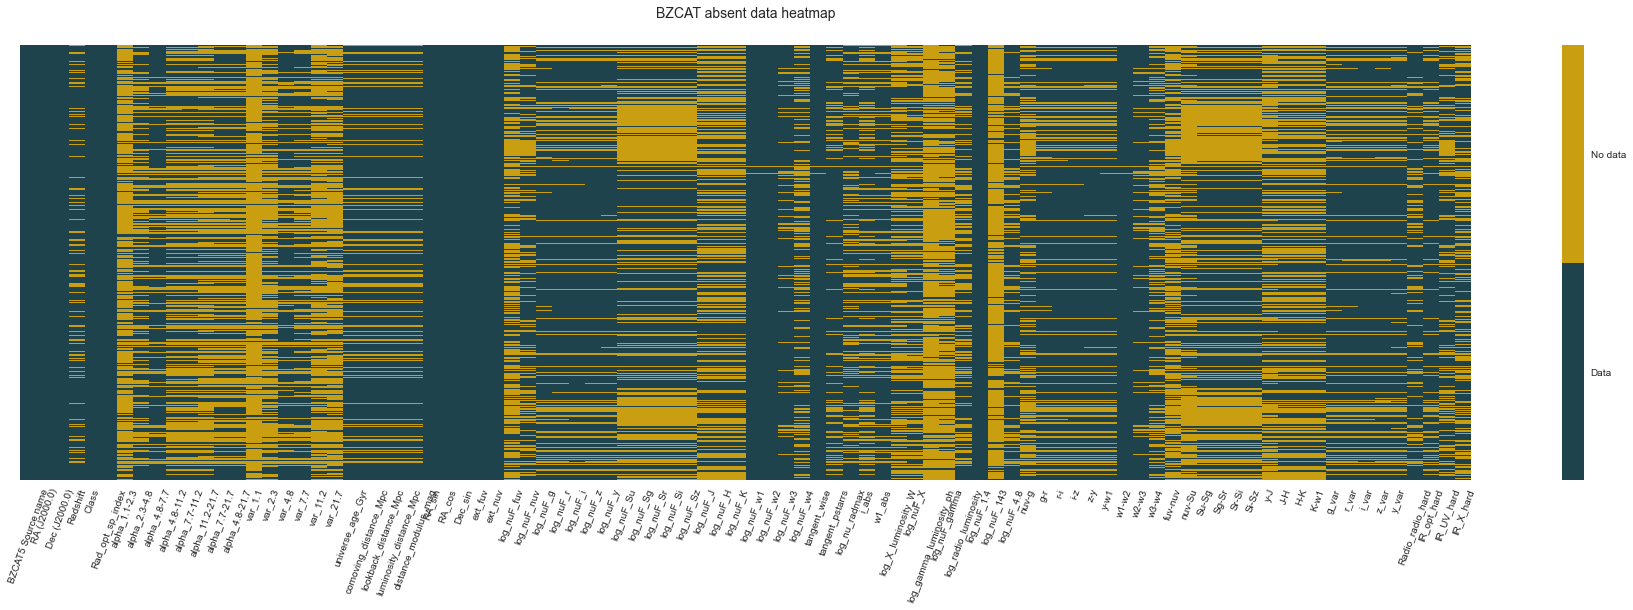

In [3]:
colors = ['#1e434c', '#c99e10'] 
fig = plt.figure(figsize=(32.5, 8))
ax = sns.heatmap(
    model_df.isnull(),  
    cmap=sns.color_palette(colors),
    yticklabels=False
)

colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0.25, 0.75])
colorbar.set_ticklabels(['Data', 'No data'])

plt.xticks(rotation=70)
ax.set_title('BZCAT absent data heatmap', y=1.05, fontsize = 14);

The fraction of missing values in some columns

In [4]:
model_df.iloc[:,100:120].isnull().mean()

Series([], dtype: float64)

Dropping columns with many missing values

In [5]:
cols_to_drop = model_df.isnull().mean() > 0.4  
cols_to_drop = cols_to_drop[cols_to_drop].index

model_df.drop(columns=cols_to_drop, inplace=True)

1. Deleting features with obvious multicollinearity (directly calculated from the redshift):
    * 'Redshift', 'universe_age_Gyr', 'comoving_distance_Mpc', 'lookback_distance_Mpc', 'luminosity_distance_Mpc', 'distance_modulus_mag'

    I'll leave the comoving distance_Mpc as the objects are more uniformly distributed over it, which may become useful for the clustering). 
2. The object names and coordinates are not necessary for the modeling.
3. The class (categorical variable) gives a trivial result at clustering: to be deleted from the model dataframe.
4. Deleting colors: the equal and more "smoothed" information are in the 'tangent_wise', 'tangent_panstarrs' features
5. Deleting optical absolute magnitudes: they were only for illustration puprposes, no K-corrections, strong correlation with distances and other features
6. Deleting UV extinctions: they are not needed for modeling

In [6]:
model_df = model_df.drop(columns=[
    'Redshift', 'universe_age_Gyr', 'lookback_distance_Mpc',
    'luminosity_distance_Mpc', 'distance_modulus_mag',
    'BZCAT5 Source name', 'Class',
    'RA (J2000.0)', 'Dec (J2000.0)', 'RA_sin', 'RA_cos', 'Dec_sin',
    'g-r', 'r-i', 'i-z', 'z-y', 'y-w1', 'w1-w2', 'w2-w3', 'w3-w4',
    'i_abs', 'w1_abs', 'ext_fuv', 'ext_nuv'])

Missing values heatmap after the dropping

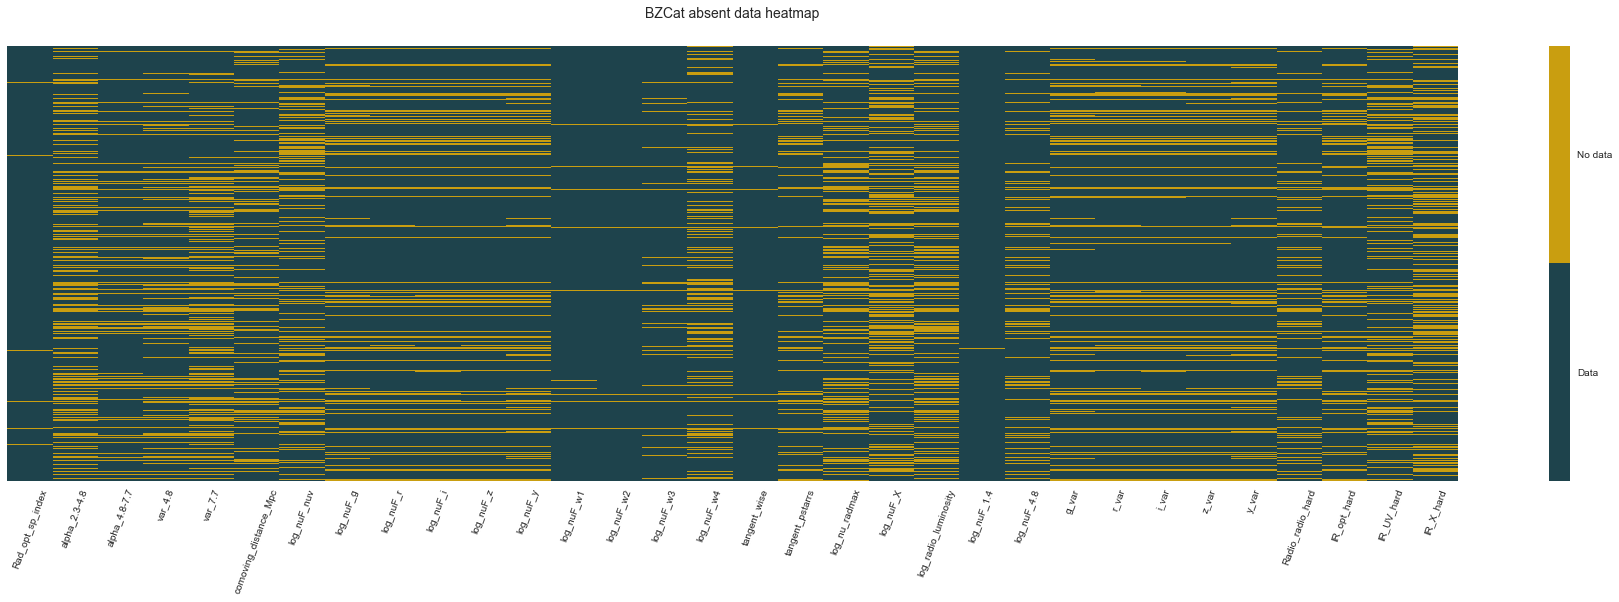

In [7]:
colors = ['#1e434c', '#c99e10'] 
fig = plt.figure(figsize=(32.5, 8))
ax = sns.heatmap(
    model_df.isnull(),  
    cmap=sns.color_palette(colors),
    yticklabels=False
)

colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0.25, 0.75])
colorbar.set_ticklabels(['Data', 'No data'])

plt.xticks(rotation=70)
ax.set_title('BZCat absent data heatmap', y=1.05, fontsize = 14);

Many features here are naturally correlated and have the same nature (like fluxes), while simulataneously having dispersed values; we will combine them further via PCA into single variables (e.g., fluxes -> flux). Nevetherless, there are other correlated features of different kinds. Let's look.

In [8]:
def get_correlated(corr_matrix, thres=0.7):
    """Getting correlated pairs from a correlation matrix 
       with correlation coefficients higher than the threshold

    Args:
        corr_matrix (pandas DataFrame): correlation matrix (e.g., from df.corr())
        thres (float, optional): threshold. Defaults to 0.7 (i.e., coeff > 0.7 or coeff < -0.7).

    Returns:
        pandas Series: correlated pairs and correlation coefficients
    """
    
    correlated_pairs = {}
    
    for col in corr_matrix.columns:
        positive_filter = corr_matrix[col] >= thres
        negative_filter = corr_matrix[col] <= -thres
        match_series = corr_matrix[col][positive_filter | negative_filter]
        for match in match_series.index:
            if match != col and match + ' -- ' + col not in correlated_pairs.keys():
                correlated_pairs.update({col + ' -- ' + match: match_series[match]})
   
    return pd.Series(correlated_pairs).sort_values()

In [9]:
cols_to_look = [
    'Rad_opt_sp_index', 'comoving_distance_Mpc', 'tangent_wise', 
    'tangent_pstarrs', 'log_nu_radmax', 'log_radio_luminosity', 
    'Radio_radio_hard', 'IR_opt_hard', 
    'IR_UV_hard', 'IR_X_hard']
get_correlated(model_df[cols_to_look].corr())

Rad_opt_sp_index -- log_radio_luminosity         0.706351
comoving_distance_Mpc -- log_radio_luminosity    0.846103
dtype: float64

I'm dropping radio luminosity, leaving the radio-to-optical spectral index and comoving distance. They also have less missing values

In [10]:
model_df.drop(columns=['log_radio_luminosity'], inplace=True)

Converting optical variabilities to the logarithmic scale

In [11]:
model_df['g_var'] = np.log(model_df['g_var'])
model_df['r_var'] = np.log(model_df['r_var'])
model_df['i_var'] = np.log(model_df['i_var'])
model_df['z_var'] = np.log(model_df['z_var'])
model_df['y_var'] = np.log(model_df['y_var'])

There is a small artificial peak near $\rm{ var}_{7.7}=1$ in the distribution of the radio variability at 7.7 GHz. Let's try to clean it.

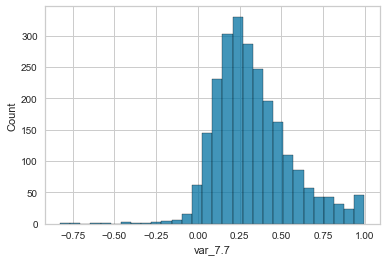

In [12]:
sns.histplot(data=model_df, x='var_7.7', bins=30);

In [13]:
# Original scatterplot
fig = px.scatter(model_df, x='var_7.7', y='var_4.8', width=650, height=400)
fig.show()

In [14]:
# Masked scatterplot
mask = (model_df['var_4.8']<0.8) & (model_df['var_7.7']>0.95)
fig = px.scatter(model_df[~mask], x='var_7.7', y='var_4.8', width=650, height=400)
fig.show()

print(f'The number of points to be converted to NaNs: '
      f'{model_df[mask].shape[0]}')

The number of points to be converted to NaNs: 32


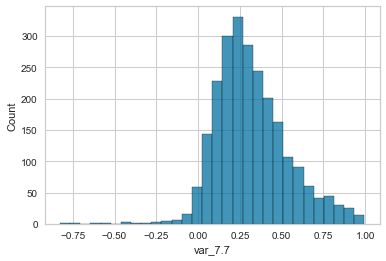

In [15]:
model_df.mask(mask, np.NaN, inplace=True)

sns.histplot(data=model_df, x='var_7.7', bins=30);

Saving the file to analyze via the Sweetviz report

In [16]:
model_df.to_csv('data/bzcat_for_profiling.csv')

**Outliers**

I'm cleaning the outliers manually by choosing from the Sweetvis report distributions. The removed objects are stored as anomalies in a separate dataframe. They don't paticipate in the clustering, but are going to be processed later using the KNN classification.

In [17]:
mask = model_df['Rad_opt_sp_index'] < -0.15
anomalies = model_df[mask].copy()
anomalies['Anomaly'] = 'Rad_opt_sp_index'
model_df = model_df[~mask]

# Further, alphas don't take part in clustering, thus no outliers filtration!!!

#mask = model_df['alpha_2.3-4.8'] < -2
#anomalies = pd.concat([anomalies, model_df[mask]])
#anomalies['Anomaly'].replace(np.NaN, 'alpha_2.3-4.8', inplace=True)
#model_df = model_df[~mask]

#mask = model_df['alpha_4.8-7.7'] < -4
#anomalies = pd.concat([anomalies, model_df[mask]])
#anomalies['Anomaly'].replace(np.NaN, 'alpha_4.8-7.7', inplace=True)
#model_df = model_df[~mask]

mask = model_df['var_4.8'] < -0.2
anomalies = pd.concat([anomalies, model_df[mask]])
anomalies['Anomaly'].replace(np.NaN, 'var_4.8', inplace=True)
model_df = model_df[~mask]

mask = model_df['var_7.7'] < -0.3
anomalies = pd.concat([anomalies, model_df[mask]])
anomalies['Anomaly'].replace(np.NaN, 'var_7.7', inplace=True)
model_df = model_df[~mask]

mask = (model_df['log_nuF_g'] < -14)  
anomalies = pd.concat([anomalies, model_df[mask]])
anomalies['Anomaly'].replace(np.NaN, 'log_nuF_g', inplace=True)
model_df = model_df[~mask]

mask = model_df['log_nuF_w1'] > -9.8
anomalies = pd.concat([anomalies, model_df[mask]])
anomalies['Anomaly'].replace(np.NaN, 'log_nuF_w1', inplace=True)
model_df = model_df[~mask]

mask = model_df['log_nuF_w2'] > -9.8
anomalies = pd.concat([anomalies, model_df[mask]])
anomalies['Anomaly'].replace(np.NaN, 'log_nuF_w2', inplace=True)
model_df = model_df[~mask]

mask = model_df['log_nuF_w3'] > -9.8
anomalies = pd.concat([anomalies, model_df[mask]])
anomalies['Anomaly'].replace(np.NaN, 'log_nuF_w3', inplace=True)
model_df = model_df[~mask]

mask = model_df['log_nuF_w4'] > -9.8
anomalies = pd.concat([anomalies, model_df[mask]])
anomalies['Anomaly'].replace(np.NaN, 'log_nuF_w4', inplace=True)
model_df = model_df[~mask]

mask = (model_df['tangent_wise'] < -1.3) | (model_df['tangent_wise'] > 3.2)
anomalies = pd.concat([anomalies, model_df[mask]])
anomalies['Anomaly'].replace(np.NaN, 'tangent_wise', inplace=True)
model_df = model_df[~mask]

mask = (model_df['tangent_pstarrs'] < -4) | (model_df['tangent_pstarrs'] > 4)
anomalies = pd.concat([anomalies, model_df[mask]])
anomalies['Anomaly'].replace(np.NaN, 'tangent_pstarrs', inplace=True)
model_df = model_df[~mask]

mask = model_df['log_nuF_X'] > -10
anomalies = pd.concat([anomalies, model_df[mask]])
anomalies['Anomaly'].replace(np.NaN, 'log_nuF_X', inplace=True)
model_df = model_df[~mask]

mask = model_df['log_nuF_1.4'] > -11.4
anomalies = pd.concat([anomalies, model_df[mask]])
anomalies['Anomaly'].replace(np.NaN, 'log_nuF_1.4', inplace=True)
model_df = model_df[~mask]

mask = model_df['log_nuF_4.8'] > -11
anomalies = pd.concat([anomalies, model_df[mask]])
anomalies['Anomaly'].replace(np.NaN, 'log_nuF_4.8', inplace=True)
model_df = model_df[~mask]

mask = model_df['g_var'] < -6
anomalies = pd.concat([anomalies, model_df[mask]])
anomalies['Anomaly'].replace(np.NaN, 'g_var', inplace=True)
model_df = model_df[~mask]

mask = model_df['r_var'] < -6
anomalies = pd.concat([anomalies, model_df[mask]])
anomalies['Anomaly'].replace(np.NaN, 'r_var', inplace=True)
model_df = model_df[~mask]

mask = model_df['i_var'] < -4
anomalies = pd.concat([anomalies, model_df[mask]])
anomalies['Anomaly'].replace(np.NaN, 'i_var', inplace=True)
model_df = model_df[~mask]

mask = model_df['z_var'] < -4.5
anomalies = pd.concat([anomalies, model_df[mask]])
anomalies['Anomaly'].replace(np.NaN, 'z_var', inplace=True)
model_df = model_df[~mask]

mask = model_df['y_var'] < -4
anomalies = pd.concat([anomalies, model_df[mask]])
anomalies['Anomaly'].replace(np.NaN, 'y_var', inplace=True)
model_df = model_df[~mask]

mask = (model_df['Radio_radio_hard']<-1.52)
anomalies = pd.concat([anomalies, model_df[mask]])
anomalies['Anomaly'].replace(np.NaN, 'Radio_radio_hard', inplace=True)
model_df = model_df[~mask]

mask = (model_df['IR_opt_hard']>1.7) 
anomalies = pd.concat([anomalies, model_df[mask]])
anomalies['Anomaly'].replace(np.NaN, 'IR_opt_hard', inplace=True)
model_df = model_df[~mask]

mask = (model_df['IR_UV_hard']<-1.25) | (model_df['IR_UV_hard']>2)
anomalies = pd.concat([anomalies, model_df[mask]])
anomalies['Anomaly'].replace(np.NaN, 'Opt_UV_hard', inplace=True)
model_df = model_df[~mask]

mask = (model_df['IR_X_hard']>2.15)
anomalies = pd.concat([anomalies, model_df[mask]])
anomalies['Anomaly'].replace(np.NaN, 'IR_X_hard', inplace=True)
model_df = model_df[~mask]

anomalies.head(3)

,Rad_opt_sp_index,alpha_2.3-4.8,alpha_4.8-7.7,var_4.8,var_7.7,comoving_distance_Mpc,log_nuF_nuv,log_nuF_g,log_nuF_r,log_nuF_i,...,g_var,r_var,i_var,z_var,y_var,Radio_radio_hard,IR_opt_hard,IR_UV_hard,IR_X_hard,Anomaly
916,-0.260,NaN,0.632,0.009,NaN,88.096983,-11.627384,-9.898098,-9.825438,-9.866171,...,NaN,NaN,NaN,NaN,-1.219426,-0.54469,-1.14664,0.614573,1.174275,Rad_opt_sp_index
2777,-0.363,NaN,-0.149,-0.029,NaN,118.733490,-11.572598,-9.977698,-9.943838,-9.995771,...,NaN,NaN,NaN,NaN,-1.417579,-0.30617,-1.11104,0.465787,0.025721,Rad_opt_sp_index
3042,-0.269,NaN,NaN,NaN,NaN,248.861612,-12.627066,-11.927978,-11.666238,-11.595371,...,-0.724845,-0.805866,-0.083489,-1.426283,-0.058583,NaN,-0.27104,0.760655,-0.160877,Rad_opt_sp_index


---

## 2. Preprocessing

In this section we deal with the first dimensionality reduction where some deeply connected physical characteristics are combined to corresponding single variables

The features of the same nature to combine to single variables (e.g., radio_vars -> radio_var). Most are correlated with each other.

In [18]:
radio_vars = ['var_4.8', 'var_7.7']                         
opt_vars = ['g_var', 'r_var', 'i_var', 'z_var', 'y_var']  
shortwl_fluxes = [
    'log_nuF_X', 'log_nuF_nuv', 'log_nuF_g', 'log_nuF_r', 'log_nuF_i', 
    'log_nuF_z', 'log_nuF_y', 'log_nuF_w1', 'log_nuF_w2', 
    'log_nuF_w3', 'log_nuF_w4']                 
radio_fluxes = ['log_nuF_1.4', 'log_nuF_4.8']

First scaling. Several scalings and several PCA transformations will be made during the project, this is due to the approach of gradual dimensionality reduction, also we use probabilistic PCA for guessing the missing values and this nonparametric method makes its own adjustments to the data processing.

In [19]:
scaler1 = StandardScaler()
model_df = pd.DataFrame(scaler1.fit_transform(model_df),
                            columns=model_df.columns, index=model_df.index)

# Save scaling model to drive
with open('data/model/scaler1.pkl', 'wb') as f:
    pickle.dump(scaler1, f)

model_df.describe()

,Rad_opt_sp_index,alpha_2.3-4.8,alpha_4.8-7.7,var_4.8,var_7.7,comoving_distance_Mpc,log_nuF_nuv,log_nuF_g,log_nuF_r,log_nuF_i,...,log_nuF_4.8,g_var,r_var,i_var,z_var,y_var,Radio_radio_hard,IR_opt_hard,IR_UV_hard,IR_X_hard
count,3.447000e+03,2.234000e+03,2.880000e+03,2.671000e+03,2.361000e+03,2.755000e+03,2.456000e+03,2.791000e+03,2.821000e+03,2.836000e+03,...,2.818000e+03,2.757000e+03,2.798000e+03,2.809000e+03,2.803000e+03,2.740000e+03,2.807000e+03,2.808000e+03,2.437000e+03,2.156000e+03
mean,1.339869e-16,1.272234e-17,2.097088e-17,-1.250300e-16,1.384370e-16,4.384474e-17,-3.413845e-16,1.720985e-15,3.719582e-15,-2.188502e-15,...,2.047412e-15,1.572111e-16,1.761755e-16,-1.580951e-17,2.709214e-16,-2.852544e-17,2.404758e-16,5.440409e-17,7.653569e-18,3.130870e-17
std,1.000145e+00,1.000224e+00,1.000174e+00,1.000187e+00,1.000212e+00,1.000182e+00,1.000204e+00,1.000179e+00,1.000177e+00,1.000176e+00,...,1.000177e+00,1.000181e+00,1.000179e+00,1.000178e+00,1.000178e+00,1.000183e+00,1.000178e+00,1.000178e+00,1.000205e+00,1.000232e+00
min,-3.828422e+00,-7.011096e+00,-5.582574e+00,-2.378347e+00,-2.901435e+00,-1.772926e+00,-2.965793e+00,-2.498466e+00,-3.344848e+00,-2.807604e+00,...,-3.289371e+00,-4.219984e+00,-4.437638e+00,-3.100030e+00,-3.623425e+00,-4.145168e+00,-4.664291e+00,-3.826845e+00,-2.617600e+00,-3.032171e+00
25%,-7.001198e-01,-5.682488e-01,-5.034142e-01,-7.353083e-01,-7.139262e-01,-8.622391e-01,-7.018303e-01,-6.936653e-01,-6.710737e-01,-6.646734e-01,...,-6.574381e-01,-6.264905e-01,-6.311031e-01,-6.303903e-01,-6.584244e-01,-6.020706e-01,-5.763022e-01,-6.852562e-01,-7.660239e-01,-6.087242e-01
50%,1.124953e-01,-1.449640e-02,4.133011e-02,-1.191690e-01,-1.730850e-01,-3.890850e-03,-4.043851e-02,-2.136534e-02,-3.329476e-02,-5.543627e-02,...,3.892756e-02,6.362485e-02,8.497220e-02,7.047019e-02,7.396186e-02,1.184784e-01,7.283633e-02,-1.421724e-01,-1.421390e-01,9.192492e-02
75%,7.551517e-01,5.909246e-01,5.765977e-01,5.829432e-01,5.705715e-01,7.898847e-01,6.768603e-01,6.418571e-01,6.294219e-01,6.217933e-01,...,6.721756e-01,6.988963e-01,6.898512e-01,6.821739e-01,7.043077e-01,6.630128e-01,6.754638e-01,5.873846e-01,6.866277e-01,6.620952e-01
max,3.081462e+00,4.057212e+00,4.177727e+00,3.262433e+00,3.255462e+00,3.034671e+00,4.653046e+00,4.861328e+00,4.973846e+00,5.075961e+00,...,3.394005e+00,2.686841e+00,2.622888e+00,2.653483e+00,3.591601e+00,2.844737e+00,3.112986e+00,4.669753e+00,3.891667e+00,3.187829e+00


**Probabilistic PCA**

Two steps:
1. Guess the missing values with probabilistic PCA (Tipping and Bishop 1999, “Mixtures of probabilistic principal component analysers”, Neural Computation 11(2),
pp. 443–482. MIT Press.). I used Ludvig Hult's code: https://github.com/el-hult/pyppca
2. Convert the features to a single principal component using the standard sklearn PCA.

In [20]:
def ppca_transform(df, cols, model_name):
    np.random.seed(42)
    
    # The PPCA algorithm produces data of the initial dimension
    # (filled in missing values)
    Y = np.array(df[cols])
    C, ss, M, X, Ye = ppca(Y, 2, False)  # Here 2d latent space (the minimum)
    
    # Reducing dimensionality to 1
    pipeline_pca1 = Pipeline([
        ('scaler', StandardScaler()),  # scaling after ppca
        ('pca', (PCA(n_components=1, random_state=42)))])  # sklearn pca
    out_col = pipeline_pca1.fit_transform(Ye)
    
    # The combined value is NaN if all initial values are NaNs 
    # (no filling with mean values)
    out_col[df[cols].isnull().all(axis=1)] = np.NaN
    
    # Saving sklearn PCA models
    filename = 'data/model/pca1_' + model_name + '.pkl'
    with open(filename, 'wb') as f:
        pickle.dump(pipeline_pca1, f)    
        
    return out_col

In [21]:
model_df['radio_var'] = ppca_transform(model_df, radio_vars, 'radio_vars')
model_df['opt_var'] = ppca_transform(model_df, opt_vars, 'opt_vars')
model_df['shortwl_flux'] = ppca_transform(model_df, shortwl_fluxes, 'shortwl_fluxes')
model_df['radio_flux'] = ppca_transform(model_df, radio_fluxes, 'radio_fluxes')
cols_drop = radio_vars + opt_vars + shortwl_fluxes + radio_fluxes
model_df.drop(columns=cols_drop, inplace=True)

scaler2 = StandardScaler()
model_df = pd.DataFrame(scaler2.fit_transform(model_df),
                        columns=model_df.columns, index=model_df.index)   
with open('data/model/scaler2.pkl', 'wb') as f:
        pickle.dump(scaler2, f)

new_cols = ['radio_var', 'opt_var', 'shortwl_flux', 'radio_flux']
bzcat[new_cols] = model_df[new_cols]

---

## 3. Clustering

Some functions

In [22]:
def plot_metrics(X):
    """Plot some metrics depending on the number of clusters"""
    inertia = []
    silhouette = []
    calinski_harabasz = []
    davis_bouldin = []
    
    for n_cl in range(2, 11):
        kmeans = cluster.KMeans(n_clusters=n_cl, random_state=42)
        kmeans.fit(X)
    
        inertia.append(kmeans.inertia_)
        silhouette.append(metrics.silhouette_score(
            X, kmeans.labels_))
        calinski_harabasz.append(metrics.calinski_harabasz_score(
            X, kmeans.labels_))
        davis_bouldin.append(metrics.davies_bouldin_score(
            X, kmeans.labels_))
        
    fig, ax = plt.subplots(1, 4, figsize=(24,5))
    
    ax[0].plot(range(2, 11), inertia, 's-', label='inertia')
    ax[1].plot(range(2, 11), silhouette, 's-', label='silhouette')
    ax[2].plot(range(2, 11), calinski_harabasz, 's-', label='calinski-harabasz')
    ax[3].plot(range(2, 11), davis_bouldin, 's-', label='davis-bouldin')
    ax[0].legend(prop={'size': 20})
    ax[1].legend(prop={'size': 20})
    ax[2].legend(prop={'size': 20})
    ax[3].legend(prop={'size': 20});
    
    
def make_kmeans_clusters(model_df, dataset_df, n_clusters, perplexity):
    """Make KMeans clusters and calculate some metrics"""
    kmeans = cluster.KMeans(n_clusters=n_clusters, random_state=42)
    dataset_df['cluster_kmeans'] = kmeans.fit_predict(model_df)
    tsne = TSNE(n_components=2, perplexity=perplexity, init='pca', 
                         learning_rate='auto', random_state=42)
    df_tsne = pd.DataFrame(tsne.fit_transform(model_df))
    df_tsne['c'] = kmeans.labels_
    sns.scatterplot(x=df_tsne[0], y=df_tsne[1], hue=df_tsne['c'], 
        palette='bright')
    plt.title('2D t-SNE representation')
    print('Silhouette: {:.3f}'.format(
        metrics.silhouette_score(model_df, kmeans.labels_)))
    print('Davis-Bouldin: {:.3f}'.format(
        metrics.davies_bouldin_score(model_df, kmeans.labels_)))
    print('Calinski-Harabatz: {:.3f}'.format(
        metrics.calinski_harabasz_score(model_df, kmeans.labels_)))
    print(f'Inertia: {kmeans.inertia_:.3f}')
    centroid_dist = pd.DataFrame(
        distance_matrix(kmeans.cluster_centers_, kmeans.cluster_centers_),
        index=range(n_clusters), columns=range(n_clusters))
    print(centroid_dist)
    
    
def yb_elbow(model_df):
    """Yellowbrick elbow visualizer"""
    vis_distortion = KElbowVisualizer(
         cluster.KMeans(), metrics='calinski_harabasz', timings=False)
    vis_distortion.fit(model_df)
    vis_distortion.show();
    
    
def plot_distr(dataset_df, cols):
    "Feature distributions for different clusters"
    plt.rcParams['axes.labelsize'] = 24
    fig, ax = plt.subplots(3, 4, figsize=(25, 10))
    i = 0
    for row in range(3):
        sns.boxplot(data=dataset_df, x=cols[i], y='cluster_kmeans', 
                    orient='h', ax=ax[row,0])
        #if row==3: break
        sns.boxplot(data=dataset_df, x=cols[i+1], y='cluster_kmeans', 
                    orient='h', ax=ax[row,1])
        sns.boxplot(data=dataset_df, x=cols[i+2], y='cluster_kmeans', 
                    orient='h', ax=ax[row,2])
        sns.boxplot(data=dataset_df, x=cols[i+3], y='cluster_kmeans', 
                    orient='h', ax=ax[row,3])
        i += 4
    plt.tight_layout()
    plt.rcParams['axes.labelsize'] = 10
    
    
def kl_div(nonans_df, filled_df, bins=10):
    """Kullback-Leibler divergence (sum for each column)"""
    kldiv = 0
    for col in nonans_df:
        hist_range = (nonans_df[col].min(), nonans_df[col].max())
        q, _ = np.histogram(nonans_df[col], bins=bins, range=hist_range)
        q = q / np.sum(q)
        p, _ = np.histogram(filled_df[col], bins=bins, range=hist_range)
        p = p / np.sum(p)
        kldiv += np.sum(rel_entr(p, q))
    print(f'Kullback-Leibler divergence: {kldiv}')
    
    
def kl_div_clusters(nonans_df, filled_df, bins=5):
    """Kullback-Leibler divergence (sum for each column and each cluster)"""
    kldiv = 0
    n_clusters = nonans_df['cluster_kmeans'].nunique()
    cols = list(nonans_df.columns)
    cols.remove('cluster_kmeans')
    for col in cols:
        for cluster in range(n_clusters):
            distr_nonan = nonans_df[nonans_df['cluster_kmeans'] == cluster][col]
            distr_filled = filled_df[filled_df['cluster_kmeans'] == cluster][col]
            hist_range = (distr_nonan.min(), distr_nonan.max())
            q, _ = np.histogram(distr_nonan, bins=bins, range=hist_range)
            q = q / np.sum(q)
            p, _ = np.histogram(distr_filled, bins=bins, range=hist_range)
            p = p / np.sum(p)
            kldiv += np.sum(rel_entr(p, q))
    print(f'Kullback-Leibler divergence: {kldiv}')

Final feature selection. I drop the alpha spectral indices: the experiments have shown that they stay pretty much the same for different clusters

In [23]:
model_df.drop(columns=['alpha_2.3-4.8', 'alpha_4.8-7.7', 'Radio_radio_hard'], inplace=True)

The final model dataframe

In [24]:
model_df

,Rad_opt_sp_index,comoving_distance_Mpc,tangent_wise,tangent_pstarrs,log_nu_radmax,IR_opt_hard,IR_UV_hard,IR_X_hard,radio_var,opt_var,shortwl_flux,radio_flux
0,0.680795,0.441440,-1.012896,NaN,-0.236207,NaN,-0.938093,1.344520,-0.383116,NaN,-0.498447,0.829585
1,0.436479,1.182501,-0.859211,1.045915,-0.290492,-0.897739,-0.410534,NaN,0.020450,0.478973,-0.122239,0.465007
2,1.796149,1.858114,-0.436155,-1.172939,-0.713959,0.773057,NaN,NaN,1.398861,-1.377994,-1.919124,0.054467
3,-0.137132,NaN,-0.040276,0.118723,NaN,0.124906,0.502705,1.082477,-0.936377,0.204669,1.041348,-0.033511
4,0.675484,-0.779418,0.721707,-0.641833,0.778626,-0.300062,-0.049712,NaN,-2.345699,0.085059,-0.847164,-0.914976
...,...,...,...,...,...,...,...,...,...,...,...,...
3556,0.617060,0.181547,-0.287729,1.443887,0.068843,-0.028578,-0.979420,0.450967,-0.962791,0.474538,0.310553,1.129242
3557,0.840131,0.352938,-0.817936,0.103518,-0.655106,0.914865,0.794562,-0.222749,1.654409,-0.452342,-0.706429,0.539347
3558,-1.459623,-1.396410,0.751222,NaN,NaN,NaN,-0.709342,-2.559045,NaN,NaN,1.694278,-0.304461
3559,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


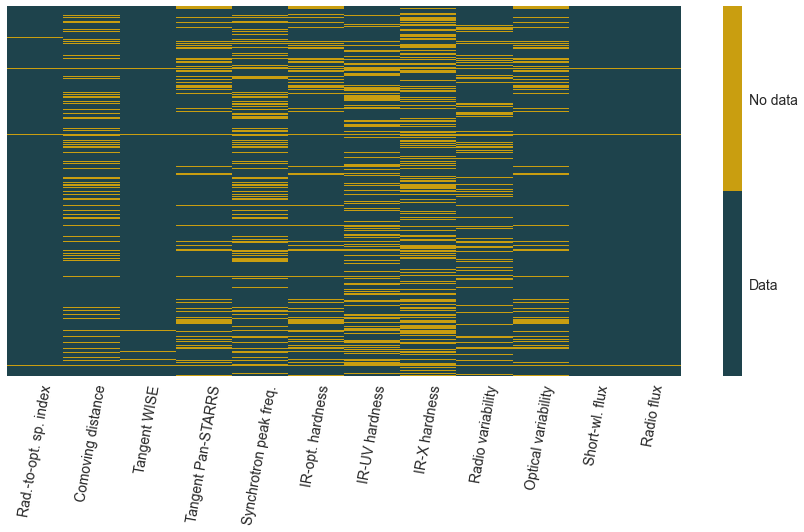

In [25]:
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

colors = ['#1e434c', '#c99e10'] 
fig = plt.figure(figsize=(12, 7.5))
ax = sns.heatmap(
    model_df.isnull(),  
    cmap=sns.color_palette(colors),
    yticklabels=False
)

colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0.25, 0.75])
colorbar.set_ticklabels(['Data', 'No data'], fontsize=14)

labels = [
    'Rad.-to-opt. sp. index', 'Comoving distance', 'Tangent WISE', 
    'Tangent Pan-STARRS', 'Synchrotron peak freq.', 'IR-opt. hardness', 
    'IR-UV hardness', 'IR-X hardness', 'Radio variability', 'Optical variability', 
    'Short-wl. flux', 'Radio flux']
ax.set_xticklabels(labels)

plt.xticks(rotation=80, fontsize=14)
#ax.set_title('Model dataset', y=1.05, fontsize=16)
plt.tight_layout()

plt.savefig('figs/model_dataset.png', format='png', bbox_inches='tight')

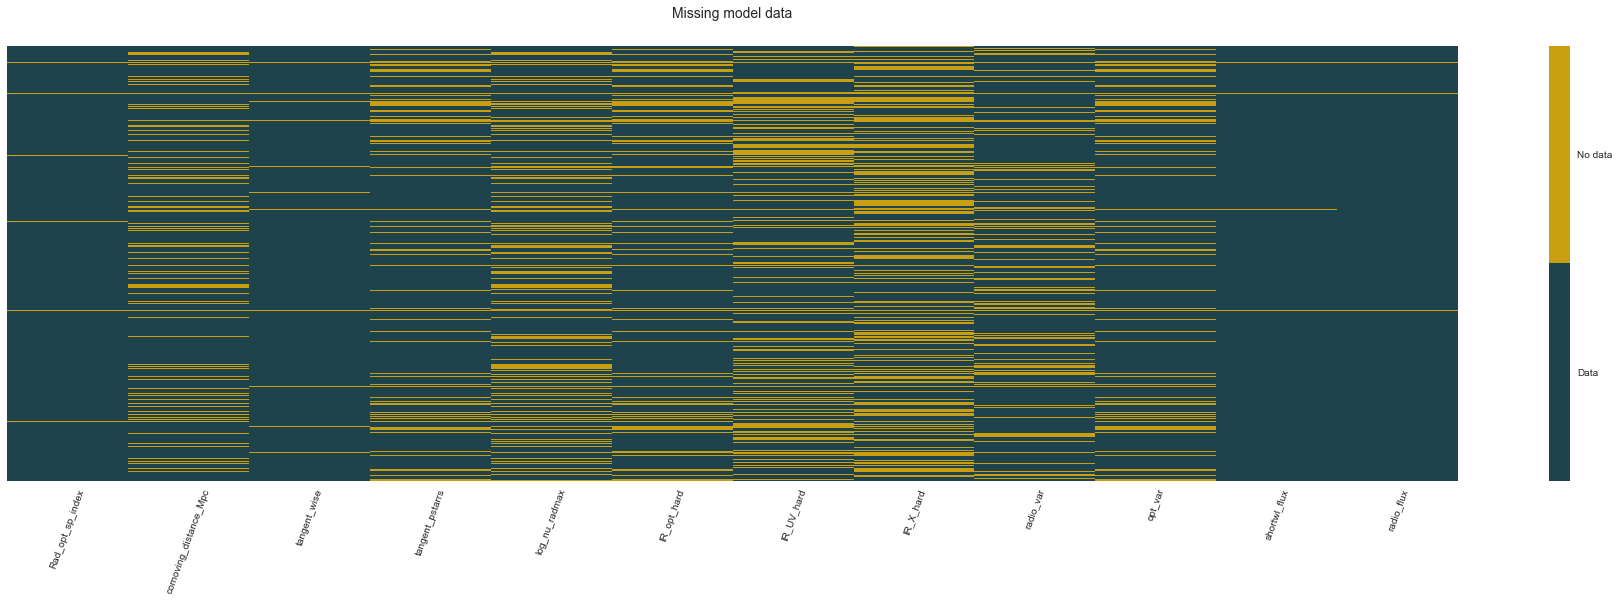

In [26]:
colors = ['#1e434c', '#c99e10'] 
fig = plt.figure(figsize=(32.5, 8))
ax = sns.heatmap(
    model_df.isnull(),  
    cmap=sns.color_palette(colors),
    yticklabels=False
)

colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0.25, 0.75])
colorbar.set_ticklabels(['Data', 'No data'])

plt.xticks(rotation=70)
ax.set_title('Missing model data', y=1.05, fontsize = 14);

### 3.1. PCA + KMeans model with all missing values dropped

In [27]:
model_pca_dropna = model_df.copy()
model_pca_dropna.dropna(inplace=True)
bzcat_pca_dropna = bzcat.iloc[model_pca_dropna.index,:].copy()

PCA dimensionality reduction with 90% dispersion explained

In [28]:
# Rescaling after NaNs dropping
scaler = StandardScaler()
model_pca_dropna = pd.DataFrame(scaler.fit_transform(model_pca_dropna),
                        columns=model_pca_dropna.columns, index=model_pca_dropna.index)

# pca
pca = PCA(n_components=0.9, random_state=42)
X = pca.fit_transform(model_pca_dropna)
print(f'The number of principal components: {pca.n_components_}')

The number of principal components: 8


Looking at the metrics (the optimal number of clusters)

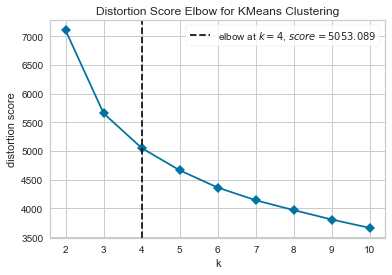

In [29]:
yb_elbow(X)

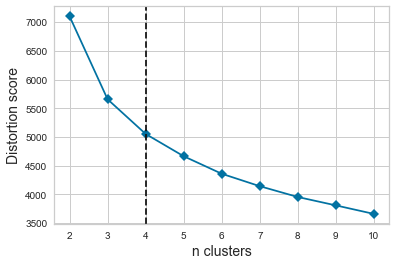

In [37]:
# Figure for the paper

vis_distortion = KElbowVisualizer(
    cluster.KMeans(), timings=False)
vis_distortion.fit(X)
#vis_distortion.show(outpath="kelbow_minibatchkmeans.eps");
vis_distortion.ax.set_xlabel('n clusters', fontsize=14)
vis_distortion.ax.set_ylabel('Distortion score', fontsize=14)
plt.savefig('./figs/elbow.eps', format='eps')

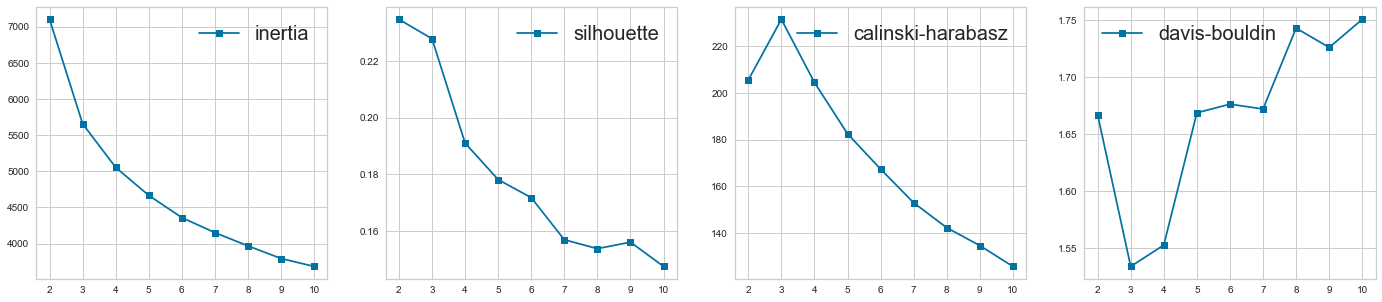

In [28]:
plot_metrics(X)

Making five clusters using K-Means. Several clustering algorithms have been tested, this is the best in our case. We also evaluate clustering metrics, distances between the centroids (in 8d space, the table), and plot the 2d and 3d representations of the 8d space (t-SNE is used: t-distributed stochastic neighbor embedding).

/home/dkudr/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Silhouette: 0.191
Davis-Bouldin: 1.553
Calinski-Harabatz: 204.546
Inertia: 5053.089
          0         1         2         3
0  0.000000  4.337545  4.271904  3.685569
1  4.337545  0.000000  3.074662  3.652284
2  4.271904  3.074662  0.000000  2.692150
3  3.685569  3.652284  2.692150  0.000000


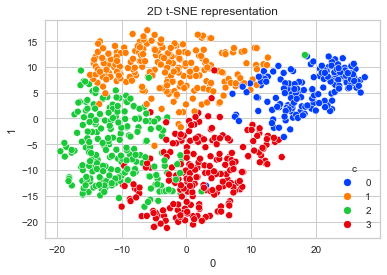

In [29]:
make_kmeans_clusters(X, bzcat_pca_dropna, 4, 50)

In [38]:
kmeans = cluster.KMeans(n_clusters=4, random_state=42)
kmeans.fit_predict(X)
tsne = TSNE(n_components=3, perplexity=50, init='pca', learning_rate='auto', 
            random_state=42)
df_tsne = pd.DataFrame(tsne.fit_transform(X))
df_tsne['c'] = kmeans.labels_
fig = px.scatter_3d(x=df_tsne[0], y=df_tsne[1], z=df_tsne[2],
              color=df_tsne['c'], width=650, height=400)
fig.update_traces(marker={'size':3}, marker_line_width=0.5)
#fig.write_html('clusters_nonans.html')
fig.show()

/home/dkudr/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Reassigning cluster numbers (based on the number of BL Lac objects in a cluster)  

In [31]:
bzcat_pca_dropna['cluster_kmeans'].replace({0:0, 1:1, 2:3, 3:2}, 
                                           inplace=True)

Cross identification with the "human" BZCAT classification. We should note that any consistency with this classification was not (and is not) a purpose of our clustering!

In [32]:
pd.crosstab(
    bzcat_pca_dropna['cluster_kmeans'], 
    bzcat_pca_dropna['Class'], margins=True)

Class,BLLac,BLLac_c,BZG,BZQ,BZU,All
cluster_kmeans,,,,,,
0,64,6,68,5,12,155
1,40,0,11,146,19,216
2,9,0,1,186,18,214
3,0,0,0,216,5,221
All,113,6,80,553,54,806


Distributions of the features used in the clustering (boxplots)

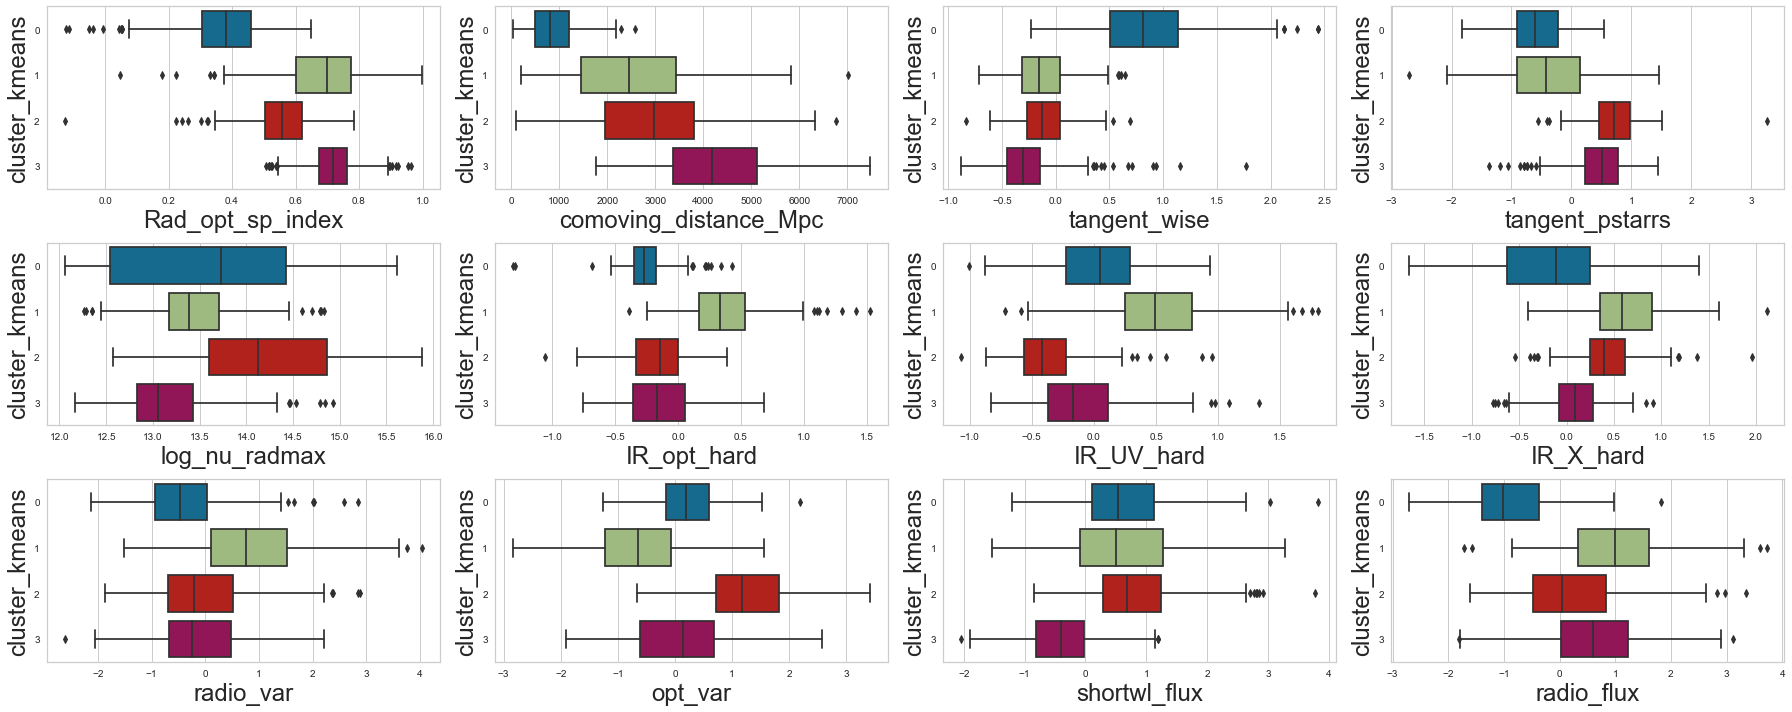

In [33]:
cols = model_df.columns
plot_distr(bzcat_pca_dropna, cols)

---

#### Output for Vlad

In [58]:
model_pca_dropna.to_csv('data/model_df_nonans.csv', index_label='index')
model_pca_dropna

,Rad_opt_sp_index,comoving_distance_Mpc,tangent_wise,tangent_pstarrs,log_nu_radmax,IR_opt_hard,IR_UV_hard,IR_X_hard,radio_var,opt_var,shortwl_flux,radio_flux
12,0.519858,0.017263,0.106732,1.820089,-0.110160,-0.097763,-1.218832,0.175840,0.344847,-0.516888,0.220079,-0.040284
13,-0.924910,1.469278,0.092772,0.356175,0.725237,-2.136598,-1.173304,0.617271,0.317143,2.268416,0.967133,-0.308255
14,0.246831,-1.132258,-1.067848,-1.920795,-0.493239,1.363464,2.589859,0.977397,0.501892,0.655037,0.628863,0.565459
15,1.162609,-0.853264,-0.620728,-0.843819,-0.658101,1.183815,1.630110,0.932151,1.292621,-0.933523,0.757909,1.747731
21,-0.543810,0.943754,-1.037623,0.864505,2.177846,-1.258675,-1.398060,0.636405,-1.045042,2.025485,0.800982,0.435796
...,...,...,...,...,...,...,...,...,...,...,...,...
3540,0.838390,2.092534,-0.883943,0.657185,-0.985084,-1.289178,0.620273,-1.373555,-0.713174,0.878069,-0.942513,0.935959
3541,-0.071701,-0.090085,-0.305061,0.680873,2.382641,-0.465665,-1.120551,0.122190,0.590198,1.185640,-0.156582,-0.022141
3551,1.378756,0.316849,-0.566966,0.104679,-0.155319,0.278410,-0.069538,0.387064,-0.992872,0.839288,-0.026763,1.441428
3556,0.571051,0.478787,-0.116780,1.291495,-0.117983,-0.174181,-0.947317,0.285330,-1.069699,0.253305,-0.087308,0.744918


In [59]:
cols = ['BZCAT5 Source name']
cols.extend(model_pca_dropna.columns)
cols.append('cluster_kmeans')
bzcat_pca_dropna[cols].to_csv('data/bzcat_nonans.csv', index_label='index')
bzcat_pca_dropna[cols]

,BZCAT5 Source name,Rad_opt_sp_index,comoving_distance_Mpc,tangent_wise,tangent_pstarrs,log_nu_radmax,IR_opt_hard,IR_UV_hard,IR_X_hard,radio_var,opt_var,shortwl_flux,radio_flux,cluster_kmeans
12,5BZQJ0005-1648,0.686,2805.673389,0.090867,1.502494,13.505542,-0.069401,-0.590259,0.357736,0.506218,-0.349812,0.603365,0.266719,2
13,5BZQJ0005+0524,0.432,5140.351819,0.083485,0.363735,14.177526,-0.799361,-0.567426,0.575815,0.477447,2.631342,1.314999,-0.027641,2
14,5BZQJ0005+3820,0.638,957.372355,-0.530242,-1.407489,13.197398,0.453760,1.319838,0.753728,0.669310,0.904517,0.992767,0.932110,1
15,5BZBJ0006-0623,0.799,1405.963973,-0.293808,-0.569724,13.064784,0.389440,0.838515,0.731375,1.490483,-0.795743,1.115694,2.230804,1
21,5BZQJ0008-2339,0.499,4295.368264,-0.514259,0.759158,15.345989,-0.485040,-0.680144,0.585268,-0.937184,2.371329,1.156725,0.789680,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3540,5BZQJ2354-1513,0.742,6142.477121,-0.432994,0.597887,12.801763,-0.495960,0.332071,-0.407709,-0.592539,1.143232,-0.504104,1.339095,3
3541,5BZUJ2354-0405,0.582,2633.069904,-0.126886,0.616313,15.510724,-0.201120,-0.540970,0.331231,0.761016,1.472429,0.244563,0.286648,2
3551,5BZQJ2357-1125,0.837,3287.374180,-0.265379,0.168099,13.469217,0.065280,-0.013876,0.462086,-0.883005,1.101724,0.368227,1.894338,3
3556,5BZQJ2358+1955,0.695,3547.753027,-0.027325,1.091307,13.499249,-0.096760,-0.454092,0.411827,-0.962791,0.474538,0.310553,1.129242,3


In [60]:
cols = ['BZCAT5 Source name']
cols.extend(model_pca_dropna.columns)
cols.extend(radio_vars)
cols.extend(opt_vars)
cols.extend(shortwl_fluxes)
cols.extend(radio_fluxes)
cols.append('cluster_kmeans')
bzcat_pca_dropna[cols].to_csv('data/bzcat_extended.csv', index_label='index')
bzcat_pca_dropna[cols]

,BZCAT5 Source name,Rad_opt_sp_index,comoving_distance_Mpc,tangent_wise,tangent_pstarrs,log_nu_radmax,IR_opt_hard,IR_UV_hard,IR_X_hard,radio_var,...,log_nuF_i,log_nuF_z,log_nuF_y,log_nuF_w1,log_nuF_w2,log_nuF_w3,log_nuF_w4,log_nuF_1.4,log_nuF_4.8,cluster_kmeans
12,5BZQJ0005-1648,0.686,2805.673389,0.090867,1.502494,13.505542,-0.069401,-0.590259,0.357736,0.506218,...,-11.929411,-11.898431,-12.058648,-12.015044,-11.998811,-12.148664,-12.042979,-13.433916,-12.918473,2
13,5BZQJ0005+0524,0.432,5140.351819,0.083485,0.363735,14.177526,-0.799361,-0.567426,0.575815,0.477447,...,-11.209851,-11.250751,-11.281648,-11.859044,-12.009211,-11.965464,-11.978180,-13.750068,-12.943095,2
14,5BZQJ0005+3820,0.638,957.372355,-0.530242,-1.407489,13.197398,0.453760,1.319838,0.753728,0.669310,...,-11.824971,-11.824351,-11.832768,-11.421844,-11.371211,-11.191464,-10.979379,-13.096476,-12.603147,1
15,5BZBJ0006-0623,0.799,1405.963973,-0.293808,-0.569724,13.064784,0.389440,0.838515,0.731375,1.490483,...,-11.744251,-11.695871,-11.921528,-11.418244,-11.354811,-11.294264,-11.152979,-12.541906,-11.916085,1
21,5BZQJ0008-2339,0.499,4295.368264,-0.514259,0.759158,15.345989,-0.485040,-0.680144,0.585268,-0.937184,...,-11.452571,-11.551511,-11.611408,-12.095844,-11.937611,-11.743064,-11.656579,-13.279841,-12.594142,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3540,5BZQJ2354-1513,0.742,6142.477121,-0.432994,0.597887,12.801763,-0.495960,0.332071,-0.407709,-0.592539,...,-12.239651,-12.281431,-12.275728,-12.729444,-12.735611,-12.515064,NaN,-12.916856,-12.391849,3
3541,5BZUJ2354-0405,0.582,2633.069904,-0.126886,0.616313,15.510724,-0.201120,-0.540970,0.331231,0.761016,...,-12.020491,-11.996351,-12.080128,-12.248244,-12.221611,-12.253064,-12.112580,-13.281000,-13.007336,2
3551,5BZQJ2357-1125,0.837,3287.374180,-0.265379,0.168099,13.469217,0.065280,-0.013876,0.462086,-0.883005,...,-12.046891,-12.085751,-12.056568,-12.054644,-11.981611,-11.969064,-11.796980,-12.595235,-12.156285,3
3556,5BZQJ2358+1955,0.695,3547.753027,-0.027325,1.091307,13.499249,-0.096760,-0.454092,0.411827,-0.962791,...,-12.000051,-12.124231,-12.127448,-12.196244,-12.096811,-12.127864,-12.142979,-13.025857,-12.489522,3


---

### 3.2. PPCA + KMeans (missing values are filled in using probabilistic PCA)

The probabilistic PCA is now apliied to the whole model dataframe to fill in the remained missing values

In [34]:
model_ppca = model_df.copy()
bzcat_ppca = bzcat.iloc[model_ppca.index,:].copy()

In [35]:
np.random.seed(42)

# Probabilistic PCA
# Number of latent variables is 7 (from best Rand index)
Y = np.array(model_ppca)
C, ss, M, X, Ye = ppca(Y, 7, False)

# Scaling after PPCA
scaler3 = StandardScaler()
X = scaler3.fit_transform(Ye)

# PCA
pca2 = PCA(n_components=0.9, random_state=42)
X = pca2.fit_transform(X)
print(f'The number of principal components: {pca2.n_components_}')

pca_features = pd.DataFrame(X)  # PCA features dataframe 
with open('data/model/scaler3.pkl', 'wb') as f:
    pickle.dump(scaler3, f)
with open('data/model/pca2.pkl', 'wb') as f:
    pickle.dump(pca2, f)

The number of principal components: 8


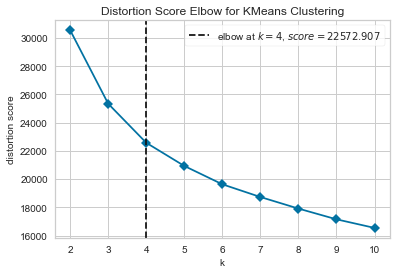

In [36]:
yb_elbow(X)

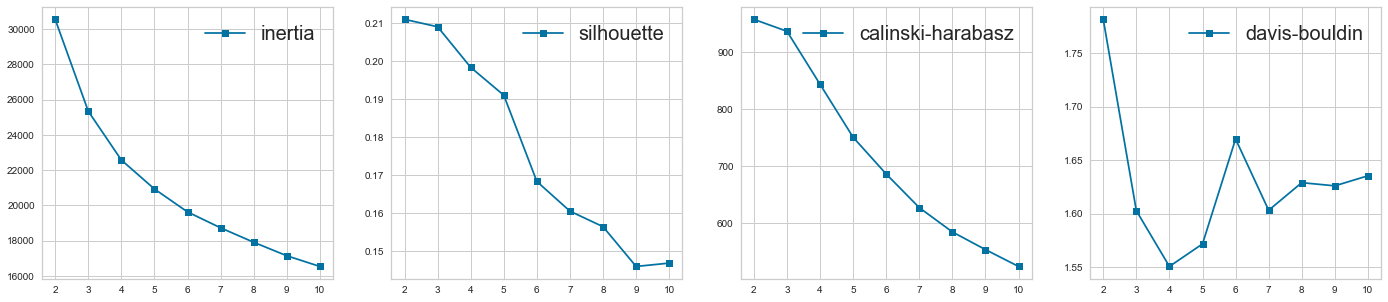

In [37]:
plot_metrics(X)

/home/dkudr/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Silhouette: 0.198
Davis-Bouldin: 1.551
Calinski-Harabatz: 843.127
Inertia: 22573.258
          0         1         2         3
0  0.000000  4.114991  3.712279  3.308726
1  4.114991  0.000000  3.056215  3.834388
2  3.712279  3.056215  0.000000  3.048414
3  3.308726  3.834388  3.048414  0.000000


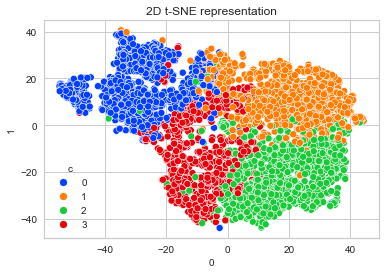

In [38]:
make_kmeans_clusters(X, bzcat_ppca, 4, 50)

In [39]:
kmeans = cluster.KMeans(n_clusters=4, random_state=42)
kmeans.fit_predict(X)
tsne = TSNE(n_components=3, perplexity=50, init='pca', learning_rate='auto', 
            random_state=42)
df_tsne = pd.DataFrame(tsne.fit_transform(X))
df_tsne['c'] = kmeans.labels_
fig = px.scatter_3d(x=df_tsne[0], y=df_tsne[1], z=df_tsne[2],
              color=df_tsne['c'], width=650, height=400)
fig.update_traces(marker={'size':3}, marker_line_width=0.5)
fig.show()

/home/dkudr/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



The Rand index shows that after filling in the missing values using PPCA, 89.2% of the objects from the "no-nans" clustering have been indentified with the same groups. We tried other methods of imputing: medians and different ML regressions, but PPCA gives the best result in metrics and in the similaries of the distributions before and after the imputing of the missing values.

In [40]:
nonan_df = bzcat_ppca.loc[bzcat_pca_dropna.index]
print('Rand index: {:.3f}'.format(
    metrics.rand_score(bzcat_pca_dropna['cluster_kmeans'], nonan_df['cluster_kmeans'])))
print('V-measure: {:.3f}'.format(
    metrics.v_measure_score(bzcat_pca_dropna['cluster_kmeans'], nonan_df['cluster_kmeans'])))

Rand index: 0.892
V-measure: 0.730


Reassigning cluster numbers so that they would correspond with the "no-nans" clustering.

In [41]:
bzcat_ppca['cluster_kmeans'].replace({0:0, 1:1, 2:3, 3:2}, 
                                           inplace=True)

pca_features['cluster'] = bzcat_ppca['cluster_kmeans'].reset_index(drop=True)

Renewed cross-identification

In [42]:
pd.crosstab(
    bzcat_ppca['cluster_kmeans'], 
    bzcat_ppca['Class'], margins=True)

Class,BLLac,BLLac_c,BZG,BZQ,BZU,All
cluster_kmeans,,,,,,
0,589,58,225,21,35,928
1,255,14,22,498,90,879
2,166,13,15,420,61,675
3,36,6,0,944,32,1018
All,1046,91,262,1883,218,3500


In [43]:
#fig = px.histogram(
#    bzcat_ppca[bzcat_ppca['cluster_kmeans']==0],
#    x='comoving_distance_Mpc',
#    title='Comoving distances (cluster 0)',
#    marginal='box',
#    width=647,
#    height=400                  
#)
#fig.layout.yaxis.title.text = 'N objects'
#fig.layout.bargap = 0.05
#fig.show()

Renewed distributions

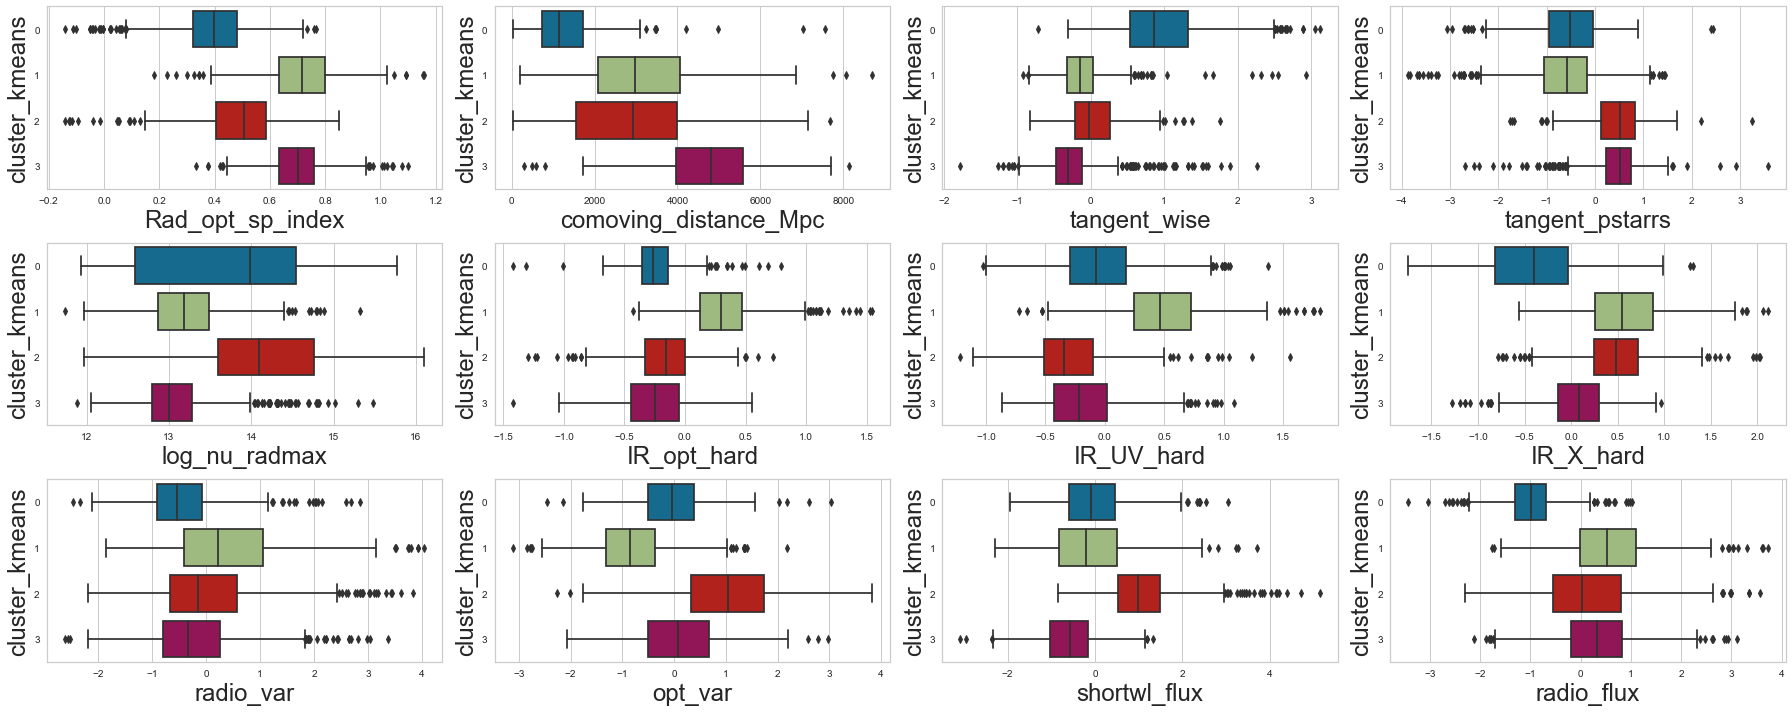

In [44]:
cols = model_df.columns
plot_distr(bzcat_ppca, cols)

---

## 4. Anomalies classification

Now we need to classify the objects previously removed as outliers

### 4.1. Anomalies dataframe preprocessing

In [45]:
pca_features['cluster'] = pca_features['cluster'].astype(int)
pred_df = anomalies.drop(columns=['Anomaly'])

In [46]:
# Models

with open('data/model/scaler1.pkl', 'rb') as f:
    scaler1 = pickle.load(f)

with open('data/model/pca1_radio_vars.pkl', 'rb') as f:
    pca1_radio_vars = pickle.load(f)

with open('data/model/pca1_opt_vars.pkl', 'rb') as f:
    pca1_opt_vars = pickle.load(f)
    
with open('data/model/pca1_shortwl_fluxes.pkl', 'rb') as f:
    pca1_shortwl_fluxes = pickle.load(f)

with open('data/model/pca1_radio_fluxes.pkl', 'rb') as f:
    pca1_radio_fluxes = pickle.load(f)

with open('data/model/scaler2.pkl', 'rb') as f:
    scaler2 = pickle.load(f)
    
with open('data/model/scaler3.pkl', 'rb') as f:
    scaler3 = pickle.load(f)

with open('data/model/pca2.pkl', 'rb') as f:
    pca2 = pickle.load(f)

Here we cannot use probabilistic PCA, because it's a non-parametric method. Thus we cannot guess any missing values without applying the method to some dataset. Whatever dataset we could have used here, the data for the anomalous objects should be included in it, and thus it would be anyway a different dataset from our main model.

For that reason, the missing values here are filled in as follows:
1. For the first PCA step (e.g., "fluxes to flux"), we use the mean value over the corresponding columns (fluxes) for each object.
2. For the second PCA step (all other NaNs), the missing values are mean values over the column (which is actually zero after the scaling).
3. Other transformations are from our main clustering model.

In [47]:
# First-step PCA for the anomalous objects

def cols_pca_transform(df, cols, pca_model):   
    X = df[cols].copy()
    
    # replace nans with the mean value in a row
    for col in cols:        
        X[col].fillna(np.mean(X[cols], axis=1), inplace=True) 
    
    # if nans are in all columns, the value to fill in 
    # doesn't actually matter (see the next step)
    X.fillna(0, inplace=True)  
    out_col = pca_model.transform(np.array(X)) 
    
    # result is nan if nans are in all columns
    out_col[df[cols].isnull().all(axis=1)] = np.NaN  
    return out_col

Applying consistently all the models according to the main clustering algorithm

In [48]:
pred_df = pd.DataFrame(scaler1.transform(pred_df),
                           columns=pred_df.columns)

pred_df['radio_var'] = cols_pca_transform(
    pred_df, radio_vars, pca1_radio_vars)
pred_df['opt_var'] = cols_pca_transform(
    pred_df, opt_vars, pca1_opt_vars)
pred_df['shortwl_flux'] = cols_pca_transform(
    pred_df, shortwl_fluxes, pca1_shortwl_fluxes)
pred_df['radio_flux'] = cols_pca_transform(
    pred_df, radio_fluxes, pca1_radio_fluxes)
cols_drop = radio_vars+opt_vars+shortwl_fluxes+radio_fluxes
pred_df.drop(columns=cols_drop, inplace=True)

pred_df = pd.DataFrame(scaler2.transform(pred_df), 
                           columns=pred_df.columns) 
new_cols = ['radio_var', 'opt_var',
             'shortwl_flux', 'radio_flux']
anomalies[new_cols] = pred_df[new_cols]

pred_df.drop(columns=['alpha_2.3-4.8', 'alpha_4.8-7.7', 'Radio_radio_hard'], inplace=True)

pred_df = scaler3.transform(np.array(pred_df))
np.nan_to_num(pred_df, copy=False)
pred_df = pd.DataFrame(pca2.transform(pred_df))

### 4.2. KNN model

Multiclass K Nearest Neighbors model with a grid-search hyperparameter optimization (as the algorithm is fast enough). The F1-score for the test sample is about 0.93 (93% of the objects are identified correctly).

In [49]:
X = pca_features.drop(columns='cluster')
y = pca_features['cluster']
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=42)

# Сетка параметров
param_grid = [
    {'n_neighbors': range(5,100),
     'weights': ['uniform', 'distance']
    }
]

# Поиск по сетке параметров с кросс-валидацией (5 фолдов)
knn_model = model_selection.GridSearchCV(
    estimator = KNeighborsClassifier(), 
    param_grid=param_grid, 
    scoring = 'f1_micro',
    cv=5, 
    n_jobs = -1
)  
knn_model.fit(X_train, y_train) 
y_train_pred = knn_model.predict(X_train)
y_test_pred = knn_model.predict(X_test)
print('Train sample F1-score: {}'.
      format(metrics.f1_score(y_train, y_train_pred, average='micro')))
print('Test sample F1-score: {}'.
      format(metrics.f1_score(y_test, y_test_pred, average='micro')))
print(f'Best hyperparameters: {knn_model.best_params_}')
print(metrics.classification_report(y_test, y_test_pred))

Train sample F1-score: 1.0
Test sample F1-score: 0.9457142857142857
Best hyperparameters: {'n_neighbors': 21, 'weights': 'distance'}
              precision    recall  f1-score   support

           0       0.96      0.98      0.97        93
           1       0.95      0.93      0.94        88
           2       0.97      0.87      0.91        67
           3       0.92      0.98      0.95       102

    accuracy                           0.95       350
   macro avg       0.95      0.94      0.94       350
weighted avg       0.95      0.95      0.95       350



Making the final BZCAT dataset with all the objects, features, and cluster labels

In [50]:
anomalies['cluster_kmeans'] = knn_model.predict(pred_df)

anomalies['Class'] = bzcat['Class']
final_df = pd.concat([bzcat_ppca, anomalies]).sort_index()
final_df.to_csv('data/BZCAT_clusters.csv', index=False)

In [51]:
anomalies

,Rad_opt_sp_index,alpha_2.3-4.8,alpha_4.8-7.7,var_4.8,var_7.7,comoving_distance_Mpc,log_nuF_nuv,log_nuF_g,log_nuF_r,log_nuF_i,...,IR_opt_hard,IR_UV_hard,IR_X_hard,Anomaly,radio_var,opt_var,shortwl_flux,radio_flux,cluster_kmeans,Class
916,-0.260,NaN,0.632,0.009,NaN,88.096983,-11.627384,-9.898098,-9.825438,-9.866171,...,-1.146640,0.614573,1.174275,Rad_opt_sp_index,NaN,NaN,NaN,NaN,2,BZG
2777,-0.363,NaN,-0.149,-0.029,NaN,118.733490,-11.572598,-9.977698,-9.943838,-9.995771,...,-1.111040,0.465787,0.025721,Rad_opt_sp_index,NaN,NaN,NaN,NaN,0,BZG
3042,-0.269,NaN,NaN,NaN,NaN,248.861612,-12.627066,-11.927978,-11.666238,-11.595371,...,-0.271040,0.760655,-0.160877,Rad_opt_sp_index,NaN,NaN,NaN,NaN,0,BZG
3208,-0.192,NaN,NaN,NaN,NaN,347.328427,-12.881230,-11.893658,-11.694038,-11.613931,...,-0.352880,0.914419,-0.267841,Rad_opt_sp_index,NaN,NaN,NaN,NaN,0,BZG
1180,0.485,-0.657,-1.711,-0.282,NaN,NaN,-12.248781,-12.169578,-11.850358,-11.925331,...,-0.214280,0.109170,NaN,var_4.8,NaN,NaN,NaN,NaN,2,BLLac
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2425,0.340,-0.475,-1.058,0.659,-0.031,1872.286006,-12.075883,-12.335018,-12.248438,-12.300411,...,-0.477200,-0.701728,-1.891554,Radio_radio_hard,NaN,NaN,NaN,NaN,0,BLLac
2551,1.002,-0.131,-0.862,0.122,0.209,4020.794639,-13.409170,-13.708138,-13.531879,-13.485691,...,1.757680,1.681159,NaN,IR_opt_hard,NaN,NaN,NaN,NaN,1,BZQ
547,0.653,-0.346,-0.296,0.294,0.537,3982.612981,-9.684560,-10.682698,-10.899838,-10.996651,...,-0.464560,-1.776651,0.091631,Opt_UV_hard,NaN,NaN,NaN,NaN,2,BZQ
1805,0.690,-0.340,-0.615,0.313,0.377,850.437845,-13.391403,-12.618378,-12.346478,-12.022211,...,1.014600,2.383792,NaN,Opt_UV_hard,NaN,NaN,NaN,NaN,1,BZG


Cross-identification for the final dataset

In [52]:
crosstab = pd.crosstab(
    final_df['cluster_kmeans'], 
    final_df['Class'], margins=True)
crosstab

Class,BLLac,BLLac_c,BZG,BZQ,BZU,All
cluster_kmeans,,,,,,
0,594,58,232,21,35,940
1,257,14,23,506,95,895
2,170,14,18,430,65,697
3,38,6,1,952,32,1029
All,1059,92,274,1909,227,3561


---

## 5. Polar diagrams

In [53]:
cols =[
    #'Rad_opt_sp_index', 
    'alpha_1.1-2.3', 'alpha_2.3-4.8', 'alpha_4.8-7.7', 
    'alpha_7.7-11.2', 'alpha_11.2-21.7', 'comoving_distance_Mpc', 
    'tangent_wise', 'tangent_pstarrs', 'log_nu_radmax', 'log_X_luminosity_W', 
    'log_gamma_luminosity_ph', 'log_radio_luminosity', 'i_abs', 'w1_abs',
    'Radio_radio_hard', 
    'Rad_opt_sp_index',
    #'Radio_IR_hard', 
    'IR_opt_hard', 'IR_UV_hard', 
    'IR_X_hard', 'radio_var', 'opt_var', 'shortwl_flux', 'radio_flux']
rename = {
    'Rad_opt_sp_index': 'Radio to optics', 'alpha_1.1-2.3': 'alp 1.1-2.3',
    'alpha_2.3-4.8': 'alp 2.3-4.8', 'alpha_4.8-7.7': 'alp 4.8-7.7',
    'alpha_7.7-11.2': 'alp 7.7-11.2', 'alpha_11.2-21.7': 'alp 11.2-21.7',
    'comoving_distance_Mpc': 'distance', 'tangent_wise': 'WISE tangent',
    'tangent_pstarrs': 'PanSTARRS tangent', 'log_nu_radmax': 'freq of max',
    'log_X_luminosity_W': 'X-ray lum', 'log_gamma_luminosity_ph': 'gamma lum',
    'log_radio_luminosity': 'radio_lum', 'i_abs': 'M in opt', 'w1_abs': 'M in IR',
    'Radio_radio_hard': 'Flux 1.4 to 4.8', 'Radio_IR_hard': 'Radio to IR',
    'IR_opt_hard': 'IR to optics', 'Opt_UV_hard': 'Optics to UV', 
    'IR_X_hard': 'IR to X', 'radio_var': 'radio var', 'opt_var': 'opt var',
    'shortwl_flux': 'shortwl fluxes', 'radio_flux': 'radio fluxes'}

medians = final_df.groupby('cluster_kmeans')[cols].median()
medians.rename(columns=rename, inplace=True)

features = medians.columns
scaler = MinMaxScaler()
medians_scaled = pd.DataFrame(scaler.fit_transform(medians), 
                              columns=features)


In [54]:
fig = make_subplots(rows=2, cols=2, specs=[[{'type': 'polar'}]*2]*2)

fig.update_layout(font_size=16)


fig.add_trace(go.Scatterpolar(
      name = "Cluster 0",
      r = medians_scaled.loc[0].values,
      theta = features,
      fill='toself',
    ), 1, 1)

fig.add_trace(go.Scatterpolar(
      name = "Cluster 1",
      r = medians_scaled.loc[1].values,
      theta = features,
      fill='toself'
    ), 1, 2)

fig.add_trace(go.Scatterpolar(
      name = "Cluster 2",
      r = medians_scaled.loc[2].values,
      theta = features,
      fill='toself'
    ), 2, 1)

fig.add_trace(go.Scatterpolar(
      name = "Cluster 3",
      r = medians_scaled.loc[3].values,
      theta = features,
      fill='toself'
    ), 2, 2)

#fig.add_trace(go.Scatterpolar(
#      name = "Cluster 4",
#      r = medians_scaled.loc[4].values,
#      theta = features,
#      fill='toself'
#    ), 3, 1)

fig.update_layout(
        showlegend=True, # отображение легенды
        autosize=False, # устаналиваем свои размеры графика
        width=1300, # ширина (в пикселях)
        height=1000, # высота (в пикселях)
    )